## 📘 Instruction Fine-Tuning (SFT)

Instruction fine-tuning is a training technique where a pretrained Large Language Model (LLM) is further trained on datasets containing **instruction → response** pairs.  
The goal is to make the model better at following human-written instructions.

---

#### 🔍 Why Instruction Fine-Tuning?

A pretrained LLM knows language and facts, but it does **not** naturally know how to:
- follow instructions precisely  
- format answers cleanly  
- provide step-by-step reasoning  
- produce helpful, safe responses  

Instruction fine-tuning aligns the model with *assistant-like behavior*.

---

#### 🧰 What Data Is Used?

Instruction fine-tuning datasets contain pairs like:

**Instruction:**  
Explain transformers in simple terms.

**Response:**  
Transformers are neural networks that use attention to understand relationships in text...

Popular datasets:
- FLAN  
- Alpaca / Self-Instruct  
- OASST  
- Databricks Dolly  
- Proprietary human-written datasets

---

#### 🧠 What Changes in the Model?

During training, the model learns to predict the *correct response tokens* given the instruction.

No new layers or heads are added — only the weights are updated based on supervised learning.

---

#### 🧪 SFT vs Pretraining vs RLHF

| Stage | Description | Purpose |
|-------|-------------|---------|
| **Pretraining** | Next-token prediction on massive corpora | Learn language + knowledge |
| **SFT (Instruction FT)** | Train on instruction–response pairs | Make model follow tasks |
| **RLHF** | Reinforcement learning using human preferences | Make model safe and helpful |

*Instruction fine-tuning = SFT (Supervised Fine-Tuning)*

---

#### ✔️ What Does Instruction FT Improve?

It enhances:
- direct question answering  
- reasoning and step-by-step responses  
- structured output generation  
- translation and summarization  
- polite and aligned behavior  
- code generation and formatting  

---

#### 📘 Simple Example

**Before Instruction FT:**  
User: “Summarize this paragraph.”  
Model: Continues writing the paragraph.

**After Instruction FT:**  
User: “Summarize this paragraph.”  
Model: Provides a concise, structured summary.

---

#### 📝 TL;DR

**Instruction fine-tuning teaches an LLM to follow human instructions using supervised datasets of instruction–response pairs.**  
It is one of the main steps that turn a raw LLM into a helpful assistant.

---

## Loading Data


In [1]:
import json

with open('instruction_data.json', 'r') as f:
    data = json.load(f)

print(f"Data Type of data : {type(data)}")
print(f"Length of Data : {len(data)}")

Data Type of data : <class 'list'>
Length of Data : 1100


In [2]:
# Lets see some examples
print(f"Example number 999 : \n {data[998]}")
print(f"Example number 300 : \n {data[299]}")

Example number 999 : 
 {'instruction': "What is the plural form of 'child'?", 'input': '', 'output': "The plural form of 'child' is 'children'."}
Example number 300 : 
 {'instruction': 'Correct the verb tense error in the sentence.', 'input': 'She go to school every day.', 'output': "The corrected sentence should be: 'She goes to school every day.'"}


In [3]:
# Now we can't just feed these examples directly, we need to combine different components of same example in a single prompt

# This Prompt can be of (Alpace Format) or (Phi-3 Format)

In [4]:
# function to convert intruction-response pairs to a single prompt
def make_alpaca_format(data):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{data['instruction']}"
    )
    input_text = f"\n\n### Input:\n{data['input']}" if data["input"] else ""

    return instruction_text + input_text

In [5]:
def make_desired_response(data):
    desired_response = f"\n\n### Response:\n{data['output']}"
    return desired_response

In [6]:
print(make_alpaca_format(data[0]))

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend


In [7]:
print(make_desired_response(data[0]))



### Response:
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".


In [8]:
# full alpace format
print(make_alpaca_format(data[0]) + make_desired_response(data[0]))

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend

### Response:
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".


In [9]:
# Splitting Data into train-val-test = 85%, 5%, 10%

train_len = int(len(data) * 0.85)
test_len = int(len(data) * 0.10)
val_len = len(data) - train_len - test_len

train_data = data[:train_len]
test_data = data[train_len:train_len+test_len]
val_data = data[train_len+test_len:]

print(f"Training examples : {train_len}")
print(f"Testing examples : {test_len}")
print(f"Validation examples : {val_len}")

Training examples : 935
Testing examples : 110
Validation examples : 55


In [10]:
# Lets make a Dataset class that takes in the data, combines its components to Alpaca format and return tensor of token ids
import torch
from torch.utils.data import Dataset, DataLoader
import random

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.encoded_text = []
        for example in data:
            alpaca_format = make_alpaca_format(example)
            response_format = make_desired_response(example)
            tokens_ids = tokenizer.encode(alpaca_format + response_format, allowed_special={"<|endoftext|>"})
            self.encoded_text.append(tokens_ids)
        random.shuffle(self.encoded_text)

    def __len__(self):
        return len(self.encoded_text)


    def __getitem__(self, idx):
        return self.encoded_text[idx]

In [11]:
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')

train_dataset = InstructionDataset(train_data, tokenizer)
test_dataset = InstructionDataset(test_data, tokenizer)
val_dataset = InstructionDataset(val_data, tokenizer)

# lets try out any example
print(train_dataset[0])

[21106, 318, 281, 12064, 326, 8477, 257, 4876, 13, 19430, 257, 2882, 326, 20431, 32543, 262, 2581, 13, 198, 198, 21017, 46486, 25, 198, 9487, 1958, 262, 1708, 2456, 416, 511, 14599, 44935, 9376, 25, 1057, 11, 3772, 11, 2952, 198, 198, 21017, 18261, 25, 198, 10987, 25, 49973, 198, 25082, 25, 1215, 752, 425, 198, 21063, 306, 25, 1215, 19011]


#### **Why are we not using DataLoader class to make loaders**
- DataLoader expects inputs in all batches to be of same shape
- But here all sentences are important, we can't truncate them or pad them for very large number
- Here comes collate_functions, which maintains consistent shape of input tensors across one batch

- This custom collate function pads the training examples in each batch to have the same length, while allowing different batches to have different lengths. This approach minimizes unnecessary padding by only extending sequences to match the longest one in each batch, not the whole dataset.

In [12]:
# so this collate function would take examples in batch, pad_them and return a batch tensor

def collate_function1(batch, pad_token=50256, device="cpu"):
    # find the max length out of the batch
    max_len = max(len(token_ids)+1 for token_ids in batch)
    input_batch = []
    # now we need to add padded tokens
    for example in batch:
        example += [pad_token]
        padded_tokens = [pad_token] * (max_len - len(example))
        example += padded_tokens
        example = torch.tensor(example[:-1])
        input_batch.append(example)

    input_batch = torch.vstack(input_batch).to(device)
    return input_batch

In [13]:
import torch

device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Device in use : {device}")

Device in use : mps


In [14]:
batch = [
    [1, 2, 3],
    [6],
    [7, 6, 2, 9, 10],
    [7, 4, 0]
]

collate_batch = collate_function1(batch, device=device)
print(f"Collated Batch : \n {collate_batch}")

Collated Batch : 
 tensor([[    1,     2,     3, 50256, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    7,     6,     2,     9,    10],
        [    7,     4,     0, 50256, 50256]], device='mps:0')


In [15]:
# we also need to have target batch tensor with input batch tensors

def collate_function2(batch, pad_token=50256, device="cpu"):
    # find the max length sequence
    max_len = max(len(token_ids)+1 for token_ids in batch)
    input_batch = []
    target_batch = []

    for example in batch:
        new_item = example
        new_item += [pad_token]
        padded_tokens= [pad_token] * (max_len - len(new_item))
        new_item += padded_tokens
        input_ids = torch.tensor(new_item[:-1])
        target_ids = torch.tensor(new_item[1:])
        input_batch.append(input_ids)
        target_batch.append(target_ids)

    input_batch = torch.vstack(input_batch).to(device)
    target_batch = torch.vstack(target_batch).to(device)

    return input_batch, target_batch

In [16]:
batch = [
    [1, 2, 3],
    [6],
    [7, 6, 2, 9, 10],
    [7, 4, 0]
]

collated_input_batch, collated_target_batch = collate_function2(batch)
print(f"Collated input batch : \n {collated_input_batch}")
print(f"Collated target batch : \n {collated_target_batch}")

Collated input batch : 
 tensor([[    1,     2,     3, 50256, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    7,     6,     2,     9,    10],
        [    7,     4,     0, 50256, 50256]])
Collated target batch : 
 tensor([[    2,     3, 50256, 50256, 50256],
        [50256, 50256, 50256, 50256, 50256],
        [    6,     2,     9,    10, 50256],
        [    4,     0, 50256, 50256, 50256]])


In [17]:
# this is upgraded collate function which will replace padded tokens with id = -100
# this helps to exclude irrelevant tokens while calculating loss

# we also need to have target batch tensor with input batch tensors

def collate_function3(batch, pad_token=50256, ignore_index=-100, allowed_max_length=None, device="cpu"):
    # find the max length sequence
    max_len = max(len(token_ids)+1 for token_ids in batch)
    input_batch = []
    target_batch = []

    for example in batch:
        new_item = example
        new_item += [pad_token]
        padded_tokens= [pad_token] * (max_len - len(new_item))
        new_item += padded_tokens
        input_ids = torch.tensor(new_item[:-1])
        target_ids = torch.tensor(new_item[1:])

        # create a mask
        mask = target_ids == pad_token
        # [0, 0, 0, 1, 1]
        indices = torch.nonzero(mask)
        # [3, 4]
        # indices.numel() tells about number of elements in a tensor
        if indices.numel() > 1:
            # replace all padded tokens with -100 except one just after ending of sentence
            # it doesn't consider that time step for calculating loss
            target_ids[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = input_ids[:allowed_max_length]
            targets = target_ids[:allowed_max_length]

        input_batch.append(input_ids)
        target_batch.append(target_ids)

    input_batch = torch.vstack(input_batch).to(device)
    target_batch = torch.vstack(target_batch).to(device)

    return input_batch, target_batch

In [18]:
batch = [
    [1, 2, 3],
    [6],
    [7, 6, 2, 9, 10],
    [7, 4, 0]
]

collated_input_batch, collated_target_batch = collate_function3(batch)
print(f"Collated input batch : \n {collated_input_batch}")
print(f"Collated target batch : \n {collated_target_batch}")

Collated input batch : 
 tensor([[    1,     2,     3, 50256, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    7,     6,     2,     9,    10],
        [    7,     4,     0, 50256, 50256]])
Collated target batch : 
 tensor([[    2,     3, 50256,  -100,  -100],
        [50256,  -100,  -100,  -100,  -100],
        [    6,     2,     9,    10, 50256],
        [    4,     0, 50256,  -100,  -100]])


#### **DataLoader**

In [19]:
# this is custom DataLoader
class CustomDataLoader:
    def __init__(self, dataset, batch_size=1):
        idx = 0
        self.X = []
        self.y = []

        while(idx != len(dataset)):
            if idx+batch_size >= len(dataset):
                break
            batch1 = dataset[:batch_size]
            input_ids, target_ids = collate_function3(batch1)
            idx += batch_size
            self.X.append(input_ids)
            self.y.append(target_ids)

    def get_loader(self):
        return self.X, self.y

In [20]:
# instead of our custom DataLoader we can also use PyTorch DataLoader, but need to define the collate function for that
# PyTorch DataLoader expects a function that takes batch only something like : collate_function(batch)

# for this purpose to prefill other arguements like device and max_length - we'll use patial function from functools

from functools import partial
customized_collate_fn = partial(collate_function3, device=device, allowed_max_length=1024)

#### **PyTorch DataLoader**

In [21]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=customized_collate_fn, shuffle=True, drop_last=True, num_workers=num_workers)

val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=customized_collate_fn, shuffle=False, drop_last=False, num_workers=num_workers)

test_loader = DataLoader(test_dataset, batch_size=batch_size,collate_fn=customized_collate_fn, shuffle=False, drop_last=False, num_workers=num_workers)

In [22]:
batch1 = next(iter(train_loader))
print(f"Number of elements in batch1 : {len(batch1)}")

print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Number of elements in batch1 : 2
Train loader:
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 59]) torch.Size([8, 59])
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 64]) torch.Size([8, 64])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 87]) torch.Size([8, 87])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 58]) torch.Size([8, 58])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 59]) torch.Size([8, 59])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 64]) torch.Size([8, 64])
torch.Size([8, 64]) torch.Size([8, 64])
torch.Size([8, 62]) torch.Size([8

#### **Loading Pre-trained LLM**

In [23]:
torch.manual_seed(123)
input_text = make_alpaca_format(val_data[0])
print(f"Input text : {input_text}")


Input text : Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [24]:
import torch

def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [25]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])



In [26]:
from gpt_download3 import download_and_load_gpt2
from GPT2_architecture import GPTModel

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [ ]:
# Downloading model
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2_medium"
)

In [30]:
# after loading your model
from gpt_download3 import load_params
settings, params = load_params('gpt2_medium/355M')

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

In [31]:
## a function to generate output token ids
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

In [68]:
# funtion to convet input text to token ids
def text_to_token_ids(input_text):
    tokenizer = tiktoken.get_encoding('gpt2')
    tokens = tokenizer.encode(input_text, allowed_special={'<|endoftext|>'})
    return tokens

def token_ids_to_text(input_ids):
    tokenizer = tiktoken.get_encoding('gpt2')
    text = tokenizer.decode(input_ids)
    return text


In [69]:
token = [2, 56, 7, 3, 48, 89, 23]
token_ids_to_text(token)

'#Y($Qz8'

In [76]:
def generate(model, input_text, max_new_tokens=35,
             context_size=BASE_CONFIG['context_length'],
             eos=50256, device='cpu'):
    
    input_ids = text_to_token_ids(input_text)

    for _ in range(max_new_tokens):
        context = input_ids[-context_size:]
        inputs = torch.tensor(context, device=device).unsqueeze(0)

        with torch.no_grad():
            logits = model(inputs)[:, -1, :]
            next_id = torch.argmax(logits, dim=-1).item()

        if next_id == eos:
            input_ids.append(eos)
            break

        input_ids.append(next_id)

    # ---- cut at EOS ----
    if eos in input_ids:
        input_ids = input_ids[:input_ids.index(eos)]
    print(f"Input ids : {input_ids}")

    return token_ids_to_text(input_ids)


In [77]:
torch.manual_seed(123)
input_text = make_alpaca_format(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [75]:
generated_text = generate(model, input_text=input_text)

print(generated_text[len(input_text):])

Input ids : [21106, 318, 281, 12064, 326, 8477, 257, 4876, 13, 19430, 257, 2882, 326, 20431, 32543, 262, 2581, 13, 198, 198, 21017, 46486, 25, 198, 3103, 1851, 262, 4075, 6827, 284, 14513, 25, 705, 464, 21221, 38383, 262, 9799, 790, 1110, 2637, 198, 198, 21017, 18261, 25, 198, 464, 9799, 373, 5597, 416, 262, 21221, 13, 50256, 198, 50256, 198, 21017, 18261, 25, 198, 464, 21221, 5597, 262, 9799, 13, 50256, 198, 50256, 50256, 50256, 50256, 198]


### Response:
The meal was prepared by the chef.<|endoftext|>
<|endoftext|>
### Response:
The chef prepared the meal.<|endoftext|>
<|endoftext|><|endoftext|><|endoftext|><|endoftext|>



In [44]:
## function to calculate batch loss
def calculate_batch_loss(model, input_batch, target_batch, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    with torch.no_grad():
        logits = model(input_batch)
        loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten(0))
    return loss

In [45]:
## function that can calculate loss of a dataloader
from tqdm import tqdm

def calc_loss_loader(model, data_loader, device):
    total_loss = 0
    for X, y in tqdm(data_loader):
        loss = calculate_batch_loss(model, X, y, device)
        total_loss += loss.item()
    total_loss /= len(data_loader)

    return total_loss

In [46]:
# lets calculate loss before training
val_data_loss = calc_loss_loader(model, val_loader, device)

print(f"Loss of val data before training : {val_data_loss}")

100%|██████████| 7/7 [00:01<00:00,  6.87it/s]

Loss of val data before training : 3.816929919379098


In [47]:
# Training configs
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
epochs = 5

In [48]:
import os
os.makedirs('./instruction_checkpoints', exist_ok=True)

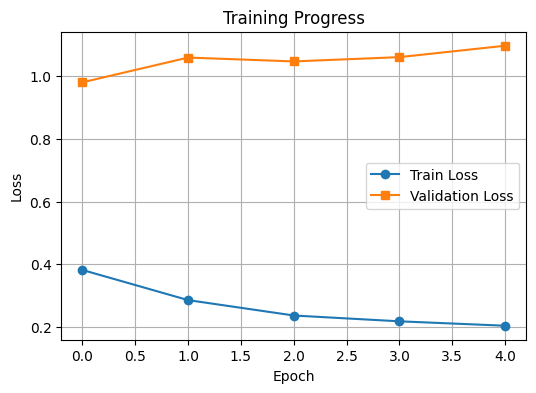

100%|██████████| 5/5 [45:15<00:00, 543.07s/it]

Epoch 5/5 | Train : 0.2043 | Val : 1.0965


In [54]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

train_loss = []
val_loss = []

for epoch in tqdm(range(epochs)):
    model.train()
    batch_train_loss = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        preds = model(X)
        loss = torch.nn.functional.cross_entropy(preds.flatten(0, 1), y.flatten(0))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        batch_train_loss += loss.item()

    batch_train_loss /= len(train_loader)
    train_loss.append(batch_train_loss)

    # calculating val loss
    with torch.no_grad():
      batch_val_loss = 0
      for X, y in val_loader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), y.flatten(0))
        batch_val_loss += loss.item()
    batch_val_loss /= len(val_loader)
    val_loss.append(batch_val_loss)

    clear_output(wait=True)
    plt.figure(figsize=(6,4))
    plt.plot(train_loss, label='Train Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='s')
    plt.title('Training Progress')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    torch.save(model.state_dict(), './instruction_checkpoints/instruction_finetuned_gpt_model.pth')
    print(f"Epoch {epoch+1}/{epochs} | Train : {train_loss[-1]:.4f} | Val : {val_loss[-1]:.4f}")



#### **Make Inference from Pretrained model**

In [36]:
import torch

model = GPTModel(BASE_CONFIG)

state_dict = torch.load("instruction_checkpoints/instruction_finetuned_gpt_model.pth", map_location='cpu')

model.load_state_dict(state_dict)

<All keys matched successfully>

In [40]:
# making inference 
example = make_alpaca_format(test_data[0])
print(example)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.


In [78]:
generated_output = generate(model, example)
print(f"Actual output : {test_data[0]['output']}")
print(f'Generated output : {generated_output[len(example):]}')

Input ids : [21106, 318, 281, 12064, 326, 8477, 257, 4876, 13, 19430, 257, 2882, 326, 20431, 32543, 262, 2581, 13, 198, 198, 21017, 46486, 25, 198, 30003, 6525, 262, 6827, 1262, 257, 985, 576, 13, 198, 198, 21017, 23412, 25, 198, 464, 1097, 318, 845, 3049, 13, 198, 198, 21017, 18261, 25, 198, 464, 1097, 318, 355, 3049, 355, 257, 1125, 316, 993, 13]
Actual output : The car is as fast as lightning.
Generated output : 

### Response:
The car is as fast as a cheetah.


In [54]:
generated_output[len(example):].replace("### Response:", "").strip()

'The car is as fast as a cheetah.<|endoftext|>\n<|endoftext|>\nThe car is as a cheetah.<|endoftext|>'

##### **See now model is able to follow instructions**

In [46]:
## Next Goal is to make an evaluation pipeline